---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>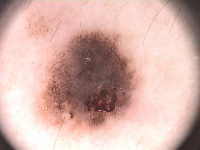</td><td>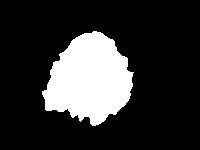</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [53]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [54]:
images = [img for img in images]
lesions = [lesion for lesion in lesions]

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [55]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

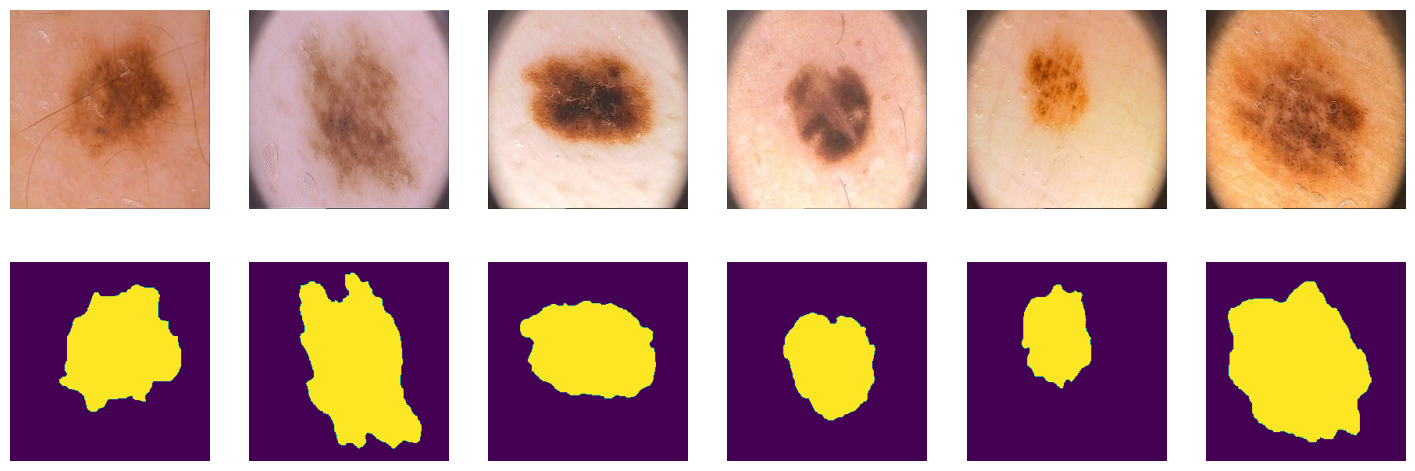

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
for x, y in data_tr:
    print(x.size())
    print(y.size())
    break

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

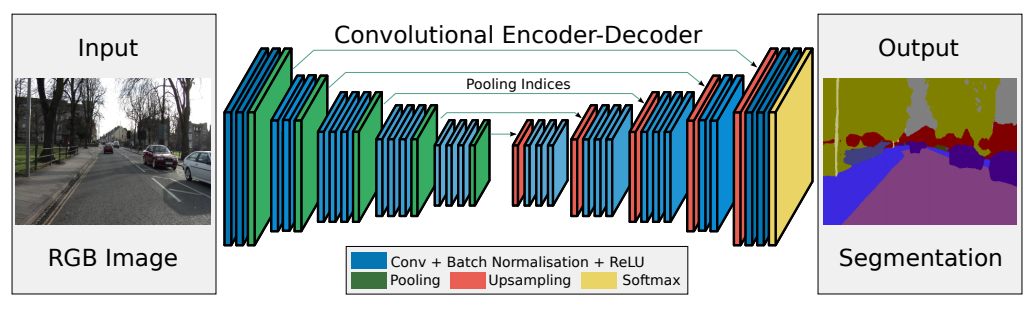

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

# это unet короче снизу реализован

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
def downsampling_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

def downsampling_block_final(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
    )

def bottleneck_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

def upsampling_block(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = downsampling_block(3, 64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = downsampling_block(64, 128)
        self.pool1 = nn.MaxPool2d(2, 2)# 128 -> 64
        self.enc_conv2 = downsampling_block(128, 256)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv3 = downsampling_block(256, 512)
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = bottleneck_block(512, 1024)

        # decoder (upsampling)
        self.upsample0 = upsampling_block(1024, 512)  # 16 -> 32
        self.dec_conv0 = downsampling_block(1024, 512) # 2x dim because of skip_connection (512+512)
        self.upsample1 = upsampling_block(512, 256)  # 32 -> 64
        self.dec_conv1 = downsampling_block(512, 256) # 2x dim because of skip_connection (256+256)
        self.upsample2 = upsampling_block(256, 128)  # 64 -> 128
        self.dec_conv2 = downsampling_block(256, 128) # 2x dim because of skip_connection (128+128)
        self.upsample3 = upsampling_block(128, 64)  # 128 -> 256
        self.dec_conv3 = downsampling_block_final(128, 64) # 2x dim because of skip_connection (64+64)

        # output
        self.conv_out = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # encoder
        # x(batch_size, 3, 256, 256)
        e0 = self.enc_conv0(x) # (batch_size, 64, 256, 256)
        e0_copy = e0.clone() # (batch_size, 64, 256, 256)
        e0 = self.pool0(e0) # (batch_size, 64, 128, 128)

        e1 = self.enc_conv1(e0) # (batch_size, 128, 128, 128)
        e1_copy = e1.clone() # (batch_size, 128, 128, 128)
        e1 = self.pool1(e1) # (batch_size, 128, 64, 64)

        e2 = self.enc_conv2(e1) # (batch_size, 256, 64, 64)
        e2_copy = e2.clone() # (batch_size, 256, 64, 64)
        e2 = self.pool2(e2) # (batch_size, 256, 32, 32)

        e3 =self.enc_conv3(e2) # (batch_size, 512, 32, 32)
        e3_copy = e3.clone() # (batch_size, 512, 32, 32)
        e3 = self.pool3(e3) # (batch_size, 512, 16, 16)

        # bottleneck
        b = self.bottleneck_conv(e3) # (batch_size, 1024, 16, 16)

        # decoder
        d0 = self.upsample0(b) # (batch_size, 512, 32, 32)
        d0 = torch.concat((d0, e3_copy), dim=1) # (batch_size, 1024, 32, 32)
        d0 = self.dec_conv0(d0) # (batch_size, 512, 32, 32)

        d1 = self.upsample1(d0) # (batch_size, 256, 64, 64)
        d1 = torch.concat((d1, e2_copy), dim=1) # (batch_size, 512, 64, 64)
        d1 = self.dec_conv1(d1) # (batch_size, 256, 64, 64)

        d2 = self.upsample2(d1) # (batch_size, 128, 128, 128)
        d2 = torch.concat((d2, e1_copy), dim=1) # (batch_size, 256, 128, 128)
        d2 = self.dec_conv2(d2) # (batch_size, 128, 128, 128)

        d3 = self.upsample3(d2) # (batch_size, 64, 256, 256)
        d3 = torch.concat((d3, e0_copy), dim=1) # (batch_size, 128, 256, 256)
        d3 = self.dec_conv3(d3) # (batch_size, 64, 256, 256)

        output = self.conv_out(d3)
        return output

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val) # detach and put into cpu
        Y_hat = Y_hat.detach().cpu().numpy()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = F.softmax(model(X_batch))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

In [ ]:
model

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (pool1): MaxPool2d(ker

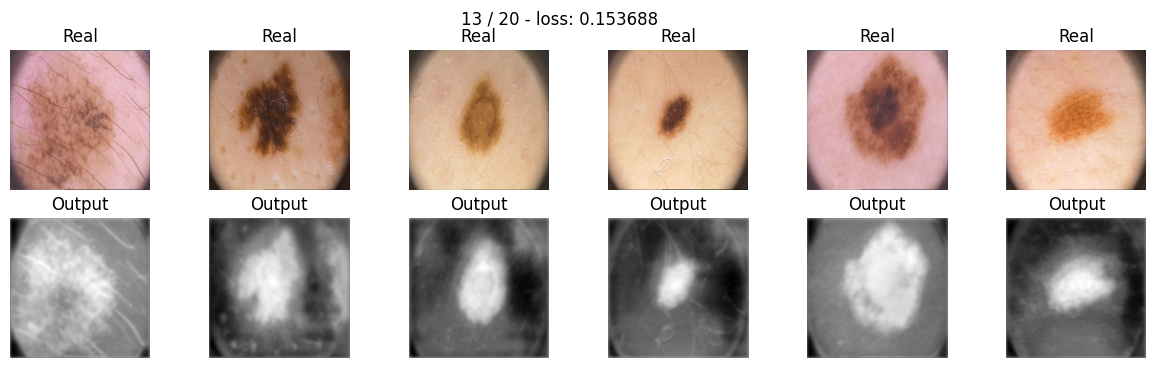

* Epoch 14/20


KeyboardInterrupt: ignored

In [ ]:
max_epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.BCEWithLogitsLoss()

train(model, optim, loss_fn, max_epochs, data_tr, data_val)

In [ ]:
needed = False
if needed:
    torch.cuda.empty_cache()

In [125]:
score_model(model, iou_pytorch, data_val)

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=coco8-seg.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

train: Scanning /content/datasets/coco8-seg/labels/train.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco8-seg/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]


Plotting labels to runs/segment/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.09G       2.63      5.028      5.241      2.827         32        640: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


                   all          4         17   0.000617     0.0333   0.000469   0.000179          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.07G      2.752      5.193      5.294      2.825         35        640: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all          4         17   0.000216     0.0167   0.000123   4.93e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         1G      3.106      5.657      6.143      2.968         18        640: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all          4         17   0.000693       0.05   0.000562   8.35e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         1G      2.899      5.551      5.572      2.808         27        640: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]

                   all          4         17   0.000888     0.0667     0.0008   0.000294          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.02G      2.734      5.354      5.468      2.933         26        640: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all          4         17   0.000604       0.05   0.000896    0.00027          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.02G      2.973       5.59      5.651      2.986         23        640: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all          4         17   0.000425     0.0333   0.000462   0.000139   0.000212     0.0167   0.000147   1.47e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.09G      3.131      5.802      5.321      2.829         32        640: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


                   all          4         17   0.000697       0.05   0.000899   0.000197   0.000232     0.0167   0.000534   0.000107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.06G       2.71      5.519      5.296       2.87         31        640: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]

                   all          4         17    0.00082       0.05   0.000709   0.000145   0.000273     0.0167   0.000733   0.000147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.981G      2.869      6.358      5.671       2.95         15        640: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

                   all          4         17   0.000729       0.05   0.000661   0.000138   0.000243     0.0167   0.000267   5.35e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.08G      2.709       5.55      5.298      2.817         30        640: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]

                   all          4         17   0.000829     0.0667   0.000659   0.000159   0.000207     0.0167   0.000215    4.3e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.06G      2.775      5.825      5.641      2.785         23        640: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]

                   all          4         17    0.00075     0.0667   0.000626   0.000119   0.000375     0.0333   0.000323   5.19e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i 2X_iY_i}{\sum_i(X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    num =
    den =
    res =
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  # hint: torch.clamp
    return your_loss


In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

# YOLO

In [10]:
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 18210, done.
remote: Counting objects: 100% (1122/1122), done.
remote: Compressing objects: 100% (682/682), done.
remote: Total 18210 (delta 670), reused 720 (delta 419), pack-reused 17088
Receiving objects: 100% (18210/18210), 10.01 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (12612/12612), done.


In [11]:
!pip install -r /content/ultralytics/requirements.txt

In [12]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 8.4 MB/s eta 0:00:00


In [123]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [124]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

UTF-8


In [122]:
!curl -L "https://universe.roboflow.com/ds/Bt08nQEwPS?key=5n3mRqBsPc" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1643      0 --:--:-- --:--:-- --:--:--  1646
100 13.8M  100 13.8M    0     0  12.4M      0  0:00:01  0:00:01 --:--:-- 31.4M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
replace data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [68]:
import zipfile
import os

# Укажите путь к zip-файлу
zip_file_path = "/content/nadine-instance-seg.v1i.yolov8.zip"

# Укажите папку, в которую вы хотите распаковать файл
extract_folder = "images_for_segmentation"

# Создайте папку, если она не существует
os.makedirs(extract_folder, exist_ok=True)

# Распаковка zip-файла
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [18]:
from ultralytics import YOLO

In [19]:
model_yolo = YOLO("yolov8n-seg.pt", task='segment')

100%|██████████| 6.73M/6.73M [00:00<00:00, 126MB/s]


In [20]:
model_yolo

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_runnin

In [46]:
model_yolo.model.model[22] # если все-таки захочется заморозить и разморозить что-нибудь

Segment(
  (cv2): ModuleList(
    (0): Sequential(
      (0): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Sequential(
      (0): Conv(
        (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [52]:
## замораживаем все слои (хз как работает на yolo)
#for param in model_yolo.parameters():
#    param.requires_grad = False
#
## размораживаем последний слой
#for param in model_yolo.model.model[22].parameters():
#    param.requires_grad = True
#
## размораживаем еще слой
#for param in model_yolo.model.model[21].parameters():
#    param.requires_grad = True
#
## размораживаем еще слой
#for param in model_yolo.model.model[20].parameters():
#    param.requires_grad = True

# before next step
## you need to create data.yaml file:
###### train: /content/datasets/images_for_segmentation/train/images
###### val: /content/datasets/images_for_segmentation/valid/images
###### test: /content/datasets/images_for_segmentation/test/images

###### nc: 1
###### names: ['nv']

#### roboflow:
######   workspace: nadine
######   project: nadine-instance-seg
######   version: 1
######   license: Public Domain
######   url: https://universe.roboflow.com/nadine/nadine-instance-seg/dataset/1

  # and put this file in main directory
  ## then put your folder with data into "datasets" folder (it's created by yolo)


In [94]:
!yolo task=segment mode=train model=yolov8n-seg.pt data=data.yaml epochs=100 imgsz=640

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False

In [97]:
!yolo segment predict model=/content/runs/segment/train8/weights/best.pt source=/content/datasets/images_for_segmentation/test/images

Ultralytics YOLOv8.0.212 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs

image 1/20 /content/datasets/images_for_segmentation/test/images/ISIC_0024311_jpg.rf.21df7a50a709d568f45dcf114ca64e03.jpg: 640x640 1 nv, 9.7ms
image 2/20 /content/datasets/images_for_segmentation/test/images/ISIC_0024352_jpg.rf.861350f0ea9197b056d33d59391fc449.jpg: 640x640 1 nv, 11.0ms
image 3/20 /content/datasets/images_for_segmentation/test/images/ISIC_0024359_jpg.rf.abbb3e9681229a2e8d0a76114ca488c5.jpg: 640x640 1 nv, 10.1ms
image 4/20 /content/datasets/images_for_segmentation/test/images/ISIC_0024366_jpg.rf.d169583022fda5fc89b30077dfc34485.jpg: 640x640 1 nv, 9.9ms
image 5/20 /content/datasets/images_for_segmentation/test/images/ISIC_0024369_jpg.rf.fc838c8096ee118640c9fc9aeb983e36.jpg: 640x640 1 nv, 9.6ms
image 6/20 /content/datasets/images_for_segmentation/test/images/ISIC_0024373_jpg.rf.ec8486aa1ad1fd52ce5e29e

## segmented images (preds)

In [106]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Путь к папке с сегментированными изображениями
image_folder = '/content/runs/segment/predict2'

# Получаем список файлов в папке
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

## base images (simple images)

In [120]:
# Путь к папке с исходными изображениями
image_folder2 = '/content/datasets/images_for_segmentation/test/images'

# Получаем список файлов в папке
image_files2 = [f for f in os.listdir(image_folder2) if f.endswith('.jpg')]

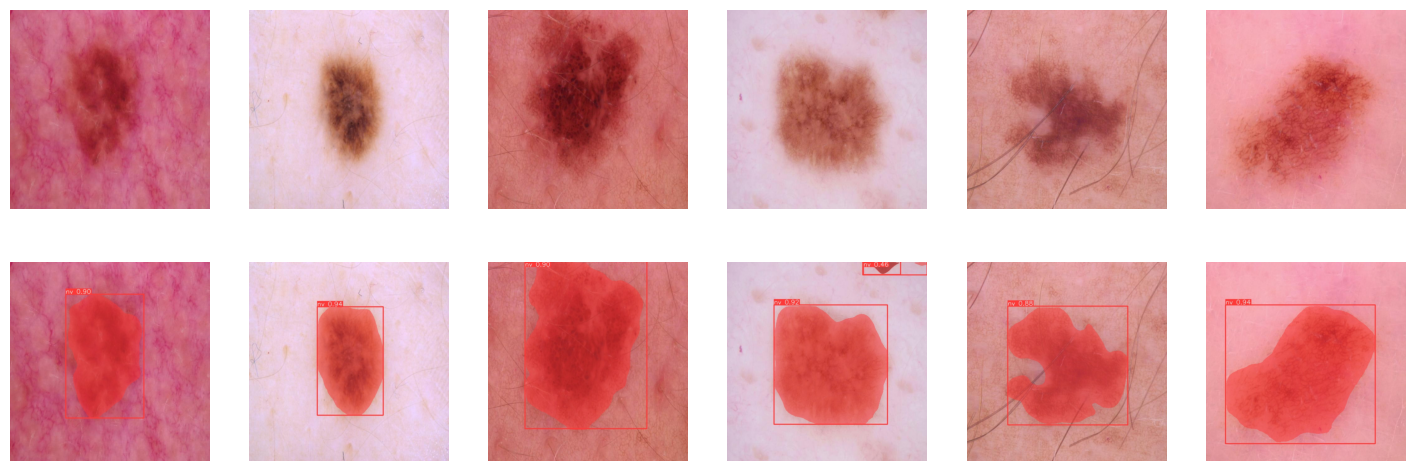

In [121]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    image_path = os.path.join(image_folder2, image_files2[i])
    img = plt.imread(image_path)
    plt.imshow(img)

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    image_path = os.path.join(image_folder, image_files[i])
    img = plt.imread(image_path)
    plt.imshow(img)
plt.show();